In [ ]:
# Init workspace
!mkdir dataset

# Download dataset and extract it
!gdown 111HiEoEvZDdg1Y2EefI6n5dA_p4sMV4V
!mv imagenet-a.tar ./dataset
!tar -xf ./dataset/imagenet-a.tar
!mv imagenet-a ./dataset

# Cleanup
!rm ./dataset/imagenet-a.tar

# (optional) Upgrading pytorch for the latest augmentation functions
#!pip install --upgrade torch torchvision torchaudio

Downloading...
From (original): https://drive.google.com/uc?id=111HiEoEvZDdg1Y2EefI6n5dA_p4sMV4V
From (redirected): https://drive.google.com/uc?id=111HiEoEvZDdg1Y2EefI6n5dA_p4sMV4V&confirm=t&uuid=e0fe48a8-32df-411a-b947-79e79d758f64
To: /content/imagenet-a.tar
100% 688M/688M [00:12<00:00, 57.1MB/s]


In [ ]:
import torch
import torch.optim as optim
from transformers import ViTForImageClassification, ViTImageProcessor
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import v2

import json
from os.path import basename, join
from pathlib import Path
import requests

import re

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SIZE = (384, 384)

In [ ]:
def load_imagenet_a_labels() -> list:

    imagenet_a = "./dataset/imagenet-a"

    with open(join(imagenet_a, "README.txt"), "r") as f:
        lines = f.readlines()

    pattern = re.compile(r"n\d{8}\s(.+)")

    labels = []

    for index, label in enumerate([line.strip() for line in lines if pattern.match(line)]):
        label = label.strip()
        label = label.split(" ")
        label = " ".join(label[1:])

        labels.append(label)

    return labels


In [ ]:
def load_model_labels() -> list[str]:

    url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
    path = Path(basename(url))

    # Check if labels file already exists
    if not path.exists():
        response = requests.get(url)
        path.write_text(response.text)

    # Load labels
    with open(path, "r") as f:
        labels = json.load(f)

    return labels

In [ ]:
def merge_labels() -> dict:

    # Map imagenet's labels with model's labels
    imagenet_a_labels = load_imagenet_a_labels()
    model_labels = load_model_labels()

    labels = {}

    for imagenet_a_index, item in enumerate(imagenet_a_labels):

        model_index = model_labels.index(item)

        labels[item] = {
            "imagenet-a": imagenet_a_index,
            "model": model_index
        }

    return labels

In [ ]:
def load_model(model_name: str = "google/vit-base-patch16-384") -> ViTForImageClassification:

    # Load the pre-trained model
    model = ViTForImageClassification.from_pretrained(model_name).to(DEVICE)

    return model

In [ ]:
def load_dataset(resize: bool = True):

    imagenet_a = "./dataset/imagenet-a/"

    # Prepare data transformations for the train loader
    transforms = [] if not resize else [T.Resize(SIZE)]
    transforms.append(T.ToTensor())
    transform = T.Compose(transforms)

    # Load data
    imagenet_a_dataset = torchvision.datasets.ImageFolder(root=imagenet_a, transform=transform)
    return torch.utils.data.DataLoader(imagenet_a_dataset, 1, shuffle=True, num_workers=8)
    # to remove dataloader: not necessary

In [ ]:
def classify_image(model: ViTForImageClassification, img: torch.Tensor) -> tuple[dict, dict]:

    # Use GPU if available
    img = img.to(DEVICE)

    # Perform inference
    model.eval()

    with torch.no_grad():
        outputs = model(img)

    # Extract probabilities from model's output logits
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1).squeeze()

    labels = load_model_labels()
    results = {}

    for index, probability in enumerate(probabilities):
        results[index] = {
            "index": index,
            "label": labels[index],
            "probability": probability.item()
        }

    predicted = probabilities.argmax(-1).item()
    predicted = {
        "index": predicted,
        "label": labels[predicted],
        "probability": probabilities[predicted].item()
    }

    return predicted, results

In [ ]:
# Load model (only once)
model = load_model()

# Load data (only once)
data_loader = load_dataset()

# Extract merged labels
merged_labels = merge_labels()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Evaluate the model (Accuracy: 18.37 %)
# accuracy = 0

# for index, img in enumerate(data_loader):

#     # Get model prediction
#     predicted, results = classify_image(model=model, img=img[0])

#     # Check if the predicted label exists inside the dataset labels
#     if predicted["label"] in merged_labels:

#         merged_label = merged_labels[predicted["label"]]

#         # Check if the prediction was correct
#         if merged_label["imagenet-a"] == img[1].item():
#             accuracy = accuracy + 1

#     print(f"Image {index+1} / {len(data_loader)} | Accuracy: {round((accuracy / (index + 1)) * 100, 2)}% ({accuracy} / {index + 1})")

# accuracy = accuracy / len(data_loader)

In [ ]:
# MEMO

data_loader = load_dataset(resize=False)

add_augmentation = lambda transformations: T.Compose(transformations)

augmentations = [
    add_augmentation([T.RandomCrop((100, 100)), T.Resize(SIZE)]),
    add_augmentation([v2.RandomChannelPermutation(), T.Resize(SIZE)])
]

augmentations = [
    T.CenterCrop((192, 192)),
    v2.RandomRotation((0, 360)),
    v2.RandomChannelPermutation(),
    v2.RandomGrayscale(),
    v2.RandomAutocontrast(),
    v2.RandomPerspective()
]

for index, img in enumerate(data_loader):

    augmentation = T.Compose([
        v2.RandomOrder(augmentations),
        T.Resize(SIZE)
    ])

    processed_img = img[0].detach().clone()
    processed_img = augmentation(processed_img)

    torchvision.utils.save_image(processed_img, "test.png")
    # Get model prediction
    predicted, results = classify_image(model=model, img=processed_img)



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


KeyboardInterrupt: Interrupted by user

In [ ]:
import matplotlib.pyplot as plt

def show_image(img):
  plt.imshow(img.squeeze(0).permute(1, 2, 0))

def show_augmentations(img1, img2):
  fig, axs = plt.subplots(1, 2)

  axs[0].imshow(img1.squeeze(0).permute(1, 2, 0))
  axs[0].set_title('Standard')
  axs[0].axis('off')  # Nasconde gli assi

  # Visualizza la seconda immagine
  axs[1].imshow(img2.squeeze(0).permute(1, 2, 0))
  axs[1].set_title('Aug')
  axs[1].axis('off')  # Nasconde gli assi
  plt.show()

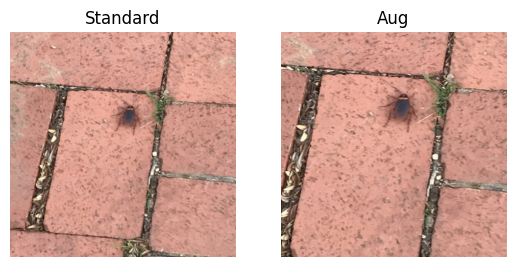

True label:  56
Predicted label:  tench
tench


In [ ]:
# MEMO

data_loader = load_dataset(resize=False)

transformation = T.Compose([
        T.Resize((500, 500)),
        # T.TenCrop(SIZE)
        T.CenterCrop((384, 384)) ])

resize_transformation = T.Compose([ T.Resize((384, 384)) ])

optimizer = optim.AdamW(model.parameters(), lr = 5e-5)
#optimizer = optim.SGD(model.parameters(), lr = 1000)
optimizer.zero_grad()

for index, img in enumerate(data_loader):

  #show_image(img[0])
  img1 = resize_transformation(img[0])
  img2 = transformation(img[0])

  imgs = [img1, img2]
  input = torch.cat(imgs, dim=0)

  show_augmentations(img1, img2)
  predicted, results = classify_image(model=model, img=img1)

  print("True label: ", img[1].item())
  print("Predicted label: ", predicted["label"])
  if predicted["label"] in merged_labels:
    print("entrato")
    merged_label = merged_labels[predicted["label"]]
    print(predicted["label"], merged_label)


  #if predicted["label"] in merged_labels:

  #merged_label = merged_labels[predicted["label"]]

         # Check if the prediction was correct
  #if merged_label["imagenet-a"] == img[1].item():
#             accuracy = accuracy + 1

    # print(f"Image {index+1} / {len(data_loader)} | Accuracy: {round((accuracy / (index + 1)) * 100, 2)}% ({accuracy} / {index + 1})")

  predicted, results = classify_image(model=model, img=img2)

  outputs1 = model(img1.to(DEVICE))
  outputs2 = model(img2.to(DEVICE))
  output = model(input.to(DEVICE))

  #print(outputs1.logits.shape, outputs2.logits.shape, output.logits.shape)
  probabilities1 = torch.nn.functional.softmax(outputs1.logits, dim=-1).squeeze()
  probabilities2 = torch.nn.functional.softmax(outputs2.logits, dim=-1).squeeze()
  probabilities = torch.nn.functional.softmax(output.logits, dim=-1).squeeze()

  marginal = torch.mean(probabilities, dim=0)

  entropy = -torch.sum(marginal * torch.log(marginal))

  entropy.backward()

  optimizer.step()

  with torch.no_grad():
    outputs3 = model(img1.to(DEVICE))

  predicted, results = classify_image(model=model, img=img1)
  probabilities3 = torch.nn.functional.softmax(outputs3.logits, dim=-1).squeeze()

  print(predicted["label"])
  #print(probabilities1 == probabilities3)
  #print(probabilities1)
  #print(probabilities2)

  break

In [ ]:
model.parameters()

In [ ]:
dir(model)